# 辛普森卡通圖像角色辨識

Alexandre Attia是美國卡通“辛普森一家”的狂熱粉絲。他看了一系列辛普森電視卡通劇集，然後想建立一個能識別其中人物角色的神經網絡。
經過一番整理之後, 他把他手上的資料集發佈到[Kaggle-The Simpsons Characters Data](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/)上讓大家可以使用與學習。

我們的任務是訓練一個卷積神經網絡來識別"辛普森一家"的卡通視頻的20個角色。

![The Simpsons characters](https://upload.wikimedia.org/wikipedia/en/thumb/c/ca/Simpsons_cast.png/440px-Simpsons_cast.png)

## 資料集說明

Alexandre仍然持續在建立與更新這個數據集（標籤圖片），新的更新資料集會會上傳到Kaggle中。請檢查文件是否有說明和解釋。

* 文件 `simpson-set.tar.gz`：這是一個圖像數據集：20個文件夾（每個字符一個），每個文件夾中有400-2000不等的圖像。

* 文件 `simpson-test-set.zip`：用來測試模型預測結果的圖像數據集

* 文件 `weights.best.h5`：己經計算過的權重

* 文件 `annotation.txt`：每個字符的邊界框的註釋文件


訓練集包括每個角色約1000個圖像。角色在圖像中的位置不一定都是位於中央，有時可能圖像中除了主要角色外也會有其他角色（但主角應該是圖片中最重要的部分）。

在這篇文章中只會訓練與辨識18個角色(別外2個角色的圖像資料仍然在持續收集中)。

### 資料準備

1. 從[Kaggle](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/kernels)點擊`Download All`下載圖像資料檔"the-simpsons-characters-dataset.zip"。
2. 在這個Jupyter Notebook所在的目錄下產生一個新的子目錄"data"。
3. 解壓縮圖像資料檔到"data"的目錄裡頭。
4. 將"kaggle_simpson_testset"目錄重新命名為"test"。
5. 在"data"的目錄裡頭產生一個新的子目錄"train"。
6. 把壓縮檔"simpsons_dataset.tar.gz"搬移到"data/train"的目錄然後進行解壓縮。

最後你的目錄結構看起來像這樣:

    2.2-simpson-characters-recognition.ipynb
    data/
    ├── test/
    │   ├── abraham_grampa_simpson_0.jpeg
    │   ├── abraham_grampa_simpson_1.jpeg
    │   ├── ..
    │   └── sideshow_bob_49.jpeg
    └── train/
        ├── abraham_grampa_simpson/
        ├── agnes_skinner/
        ├── ..
        └── waylon_smithers/

In [1]:
# 匯入相關所需的模組
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import glob
import time
from random import shuffle
from collections import Counter

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


## 資料預處理 (Data Preprocessing)
預處理圖片的第一步是調整它們的大小。我們需要有相同大小的所有照片進行訓練。
我會將數據資料轉換型別為`float32`來節省一些記憶的用量並對它們進行歸一化（除以255）。

然後，我用數字代替每一個卡通每一個角色的名稱，並感謝Keras，我可以快速地將這些類別轉換為向量：

In [2]:
# 卡通角色的Label-encoding
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

img_width = 42 
img_height = 42


num_classes = len(map_characters) # 要辨識的角色種類

pictures_per_class = 1000 # 每個角色會有接近1000張訓練圖像
test_size = 0.15

imgsPath = "data/train"

In [3]:
# 將訓練資料圖像從檔案系統中取出並進行
def load_pictures():
    pics = []
    labels = []
    
    for k, v in map_characters.items(): # k: 數字編碼 v: 角色label
        # 把某一個角色在檔案夾裡的所有圖像檔的路徑捉出來
        pictures = [k for k in glob.glob(imgsPath + "/" + v + "/*")]        
        print(v + " : " + str(len(pictures))) # 看一下每個角色有多少訓練圖像
        for i, pic in enumerate(pictures):
            tmp_img = cv2.imread(pic)
            
            # 由於OpenCv讀圖像時是以BGR (Blue-Green-Red), 我們把它轉置成RGB (Red-Green-Blue)
            tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
            tmp_img = cv2.resize(tmp_img, (img_height, img_width)) # 進行大小歸一位            
            pics.append(tmp_img)
            labels.append(k)    
    return np.array(pics), np.array(labels)

# 取得訓練資料集與驗證資料集
def get_dataset(save=False, load=False):
    if load: 
        # 從檔案系統中載入之前處理保存的訓練資料集與驗證資料集
        h5f = h5py.File('dataset.h5','r')
        X_train = h5f['X_train'][:]
        X_test = h5f['X_test'][:]
        h5f.close()
        
        # 從檔案系統中載入之前處理保存的訓練資料標籤與驗證資料集籤
        h5f = h5py.File('labels.h5', 'r')
        y_train = h5f['y_train'][:]
        y_test = h5f['y_test'][:]
        h5f.close()
    else:
        # 從最原始的圖像檔案開始處理
        X, y = load_pictures()
        y = keras.utils.to_categorical(y, num_classes) # 目標的類別種類數
        
        # 將資料切分為訓練資料集與驗證資料集 (85% vs. 15%)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
        if save: # 保存尚未進行歸一化的圖像數據
            h5f = h5py.File('dataset.h5', 'w')
            h5f.create_dataset('X_train', data=X_train)
            h5f.create_dataset('X_test', data=X_test)
            h5f.close()
            
            h5f = h5py.File('labels.h5', 'w')
            h5f.create_dataset('y_train', data=y_train)
            h5f.create_dataset('y_test', data=y_test)
            h5f.close()
    
    # 進行圖像每個像素值的型別轉換與歸一化處理
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print("Train", X_train.shape, y_train.shape)
    print("Test", X_test.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test   

In [4]:
# 取得訓練資料集與驗證資料集  
X_train, X_test, y_train, y_test = get_dataset(save=True, load=False)

abraham_grampa_simpson : 913
apu_nahasapeemapetilon : 623
bart_simpson : 1342
charles_montgomery_burns : 1193
chief_wiggum : 986
comic_book_guy : 469
edna_krabappel : 457
homer_simpson : 2246
kent_brockman : 498
krusty_the_clown : 1206
lisa_simpson : 1354
marge_simpson : 1291
milhouse_van_houten : 1079
moe_szyslak : 1452
ned_flanders : 1454
nelson_muntz : 358
principal_skinner : 1194
sideshow_bob : 877
Train (16143, 42, 42, 3) (16143, 18)
Test (2849, 42, 42, 3) (2849, 18)


## 網絡模型 (Model)

現在我們來定義我們的模型架構。我們將使用具有6個卷積層的前饋網絡，然後是完全連接的隱藏層。
我們也將在兩者之間使用Dropout層來防止網絡"過擬合(overfitting)"。

In [5]:
def create_model_six_conv(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model;

#圖像的shape是 (42,42,3)
model = create_model_six_conv((img_height, img_width, 3)) # 初始化一個模型
model.summary() # 秀出模型架構

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 42, 42, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 64)          0         
__________

在訓練模型之前，我們需要將模型配置為學習算法並進行編譯。我們需要指定:
loss: 損失函數，我們要優化。我們不能使用MSE，因為它是不連續的數值。因此，我們使用：categorical_crossentropy
optimizer: 我們使用標準隨機梯度下降(Stochastic gradient descent)與涅斯捷羅夫動量(Nesterov momentum)
metric: 由於我們正在處理一個分類問題，我們用度量是accuracy。

In [6]:
# 讓我們先配置一個常用的組合來作為後續優化的基準點
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

## 訓練 (Training)

現在，我們的模型已經準備好了。在訓練期間，我們的模型將進行迭代批量訓練，每個次的訓練資料的大小為batch_size。對於每批次，模型將會計算出梯度(gradient)，並自動更新網絡的權重。對所有訓練集的一次迭代被稱為一次的循環(epoch)。訓練通常會一直進行到損失收斂於一個常數。


我們將增加一些功能到我們的訓練設定：
* `Learning rate scheduler`: 隨著訓練循環的次數逐漸增加的過程中對權重調整的學習率進行衰減通常有助於讓模型學習更好
* `Model checkpoint`: 我們將比對每個訓練循環的驗證準確度並只保存模型表現最好的模型。這對深度學度來說是很有用的設定，因為我們的網絡可能在一定數量的訓練循環後開始過擬合(overfitting)，但是我們需要在整過訓練過程中表現最好的模型留下來。

這些設定不是必須的，但它們的確可以提高模型的準確性。這些功能是通過Keras的`callback`功能來實現的。`callback`是一組函式，將在訓練過程的特定階段被應用，比如將訓練結束。 Keras提供內置的學習速率調度([learning rate scheduling](https://keras.io/callbacks/#learningratescheduler) )和模型檢查點功能([model checkpointing](https://keras.io/callbacks/#modelcheckpoint))。

In [7]:
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

batch_size = 32
epochs = 30

history = model.fit(X_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_test, y_test),
         shuffle=True,
         callbacks=[LearningRateScheduler(lr_schedule),
             ModelCheckpoint('model.h5', save_best_only=True)
         ])

Train on 16143 samples, validate on 2849 samples
Epoch 1/30
16143/16143 [==============================] - 5s 327us/step - loss: 2.5824 - acc: 0.1880 - val_loss: 2.2157 - val_acc: 0.2724
Epoch 2/30
16143/16143 [==============================] - 4s 273us/step - loss: 2.0024 - acc: 0.3707 - val_loss: 1.6648 - val_acc: 0.4921
Epoch 3/30
16143/16143 [==============================] - 4s 271us/step - loss: 1.4913 - acc: 0.5370 - val_loss: 1.2448 - val_acc: 0.6181
Epoch 4/30
16143/16143 [==============================] - 4s 273us/step - loss: 1.1473 - acc: 0.6464 - val_loss: 1.0138 - val_acc: 0.6813
Epoch 5/30
16143/16143 [==============================] - 5s 283us/step - loss: 0.9368 - acc: 0.7106 - val_loss: 0.8159 - val_acc: 0.7536
Epoch 6/30
16143/16143 [==============================] - 4s 267us/step - loss: 0.7933 - acc: 0.7552 - val_loss: 0.6492 - val_acc: 0.7978
Epoch 7/30
16143/16143 [==============================] - 5s 292us/step - loss: 0.6810 - acc: 0.7932 - val_loss: 0.6277 - v

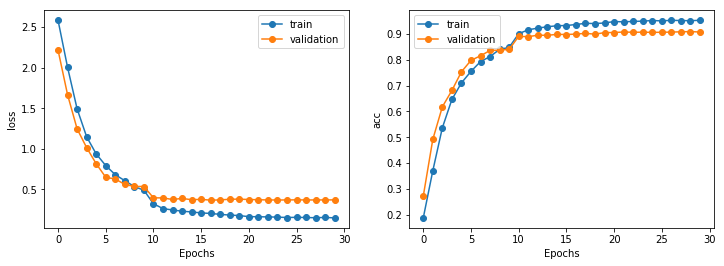

In [8]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc')

plt.show()

從以上兩個趨勢圖看來我們的訓練模式的表現不錯, 也沒有明顯的過擬合(overfitting)的現象。

## 驗證評估 (Evaluation)

### 加載測試數據
讓我們加載測試數據並評估我們的模型

In [9]:
import os
from pathlib import PurePath # 處理不同作業系統file path的解析問題 (*nix vs windows)

# 載入要驗證模型的數據
def load_test_set(path):
    pics, labels = [], []
    reverse_dict = {v:k for k,v in map_characters.items()}
    for pic in glob.glob(path+'*.*'):
        char_name = "_".join(os.path.basename(pic).split('_')[:-1])
        if char_name in reverse_dict:
            temp = cv2.imread(pic)
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
            temp = cv2.resize(temp, (img_height,img_width)).astype('float32') / 255.
            pics.append(temp)
            labels.append(reverse_dict[char_name])
    X_test = np.array(pics)
    y_test = np.array(labels)
    y_test = keras.utils.to_categorical(y_test, num_classes) # 進行one-hot編碼
    print("Test set", X_test.shape, y_test.shape)
    return X_test, y_test

imgsPath = "data/test/"

#載入數據
X_valtest, y_valtest = load_test_set(imgsPath)

Test set (890, 42, 42, 3) (890, 18)


### 計算預測的正確率

In [10]:
# 預測與比對
from keras.models import load_model

# 把訓練時val_loss最小的模型載入
model = load_model('model.h5')

# 預測與比對
y_pred = model.predict_classes(X_valtest)
acc = np.sum(y_pred==np.argmax(y_valtest, axis=1))/np.size(y_pred)
print("Test accuracy = {}".format(acc))

890/890 [==============================] - 0s 123us/step
Test accuracy = 0.9640449438202248


### 96%的正確率 ~~ 太神奇了, 傑克!!

## 圖像增強 (Data Augmentation)

在原有的資料集的訓練裡頭, 我們達到了將近96.7%的準確率。讓我們試著使用圖像增強的手法來看看是否可以再提高一些效能。

讓我們直接使用keras的內置功能來完成圖像增強 (Data Augmentation)。

In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# 保存在訓練過程中比較好的模型
filepath="model-dtaug.h5"

# 保留"val_acc"最好的那個模型
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

# 定義學習率遞減的原則
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

#圖像的shape是 (42,42,3)
model = create_model_six_conv((img_height, img_width, 3)) # 初始化一個模型

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

callbacks_list = [LearningRateScheduler(lr_schedule) ,checkpoint]
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            epochs=epochs,
                            validation_data=(X_test, y_test),
                            callbacks=callbacks_list)

Epoch 1/30
505/504 [==============================] - 6s 12ms/step - loss: 2.6085 - acc: 0.1775 - val_loss: 2.1726 - val_acc: 0.3229
Epoch 2/30
505/504 [==============================] - 6s 11ms/step - loss: 2.0002 - acc: 0.3738 - val_loss: 1.6682 - val_acc: 0.4767
Epoch 3/30
505/504 [==============================] - 6s 11ms/step - loss: 1.5639 - acc: 0.5187 - val_loss: 1.2101 - val_acc: 0.6314
Epoch 4/30
505/504 [==============================] - 6s 11ms/step - loss: 1.2528 - acc: 0.6178 - val_loss: 0.8892 - val_acc: 0.7269
Epoch 5/30
505/504 [==============================] - 6s 11ms/step - loss: 1.0483 - acc: 0.6785 - val_loss: 0.8380 - val_acc: 0.7399
Epoch 6/30
505/504 [==============================] - 6s 11ms/step - loss: 0.8988 - acc: 0.7267 - val_loss: 0.6980 - val_acc: 0.7908
Epoch 7/30
505/504 [==============================] - 6s 11ms/step - loss: 0.7999 - acc: 0.7555 - val_loss: 0.5642 - val_acc: 0.8298
Epoch 8/30
505/504 [==============================] - 6s 11ms/step - 

### 計算預測的正確率

In [12]:
# 預測與比對
from keras.models import load_model

# 把訓練時val_loss最小的模型載入
model = load_model('model-dtaug.h5')

# 預測與比對
y_pred = model.predict_classes(X_valtest)
acc = np.sum(y_pred==np.argmax(y_valtest, axis=1))/np.size(y_pred)
print("Test accuracy = {}".format(acc))

890/890 [==============================] - 0s 140us/step
Test accuracy = 0.9337078651685393


### 預測結果視覺化

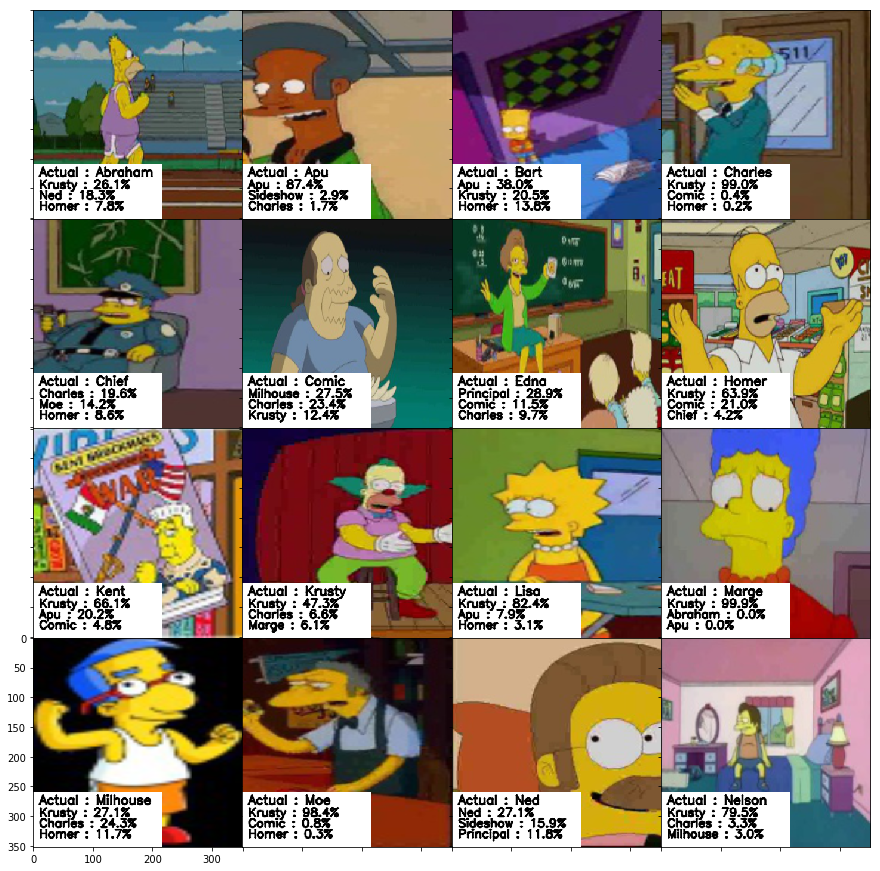

In [14]:
# 預測與比對
from keras.models import load_model
from mpl_toolkits.axes_grid1 import AxesGrid

# 把訓練時val_loss最小的模型載入
model = load_model('model.h5')

F = plt.figure(1, (15,20))
grid = AxesGrid(F, 111, nrows_ncols=(4, 4), axes_pad=0, label_mode="1")

for i in range(16):
    char = map_characters[i]
    image = cv2.imread(np.random.choice([k for k in glob.glob('data/test/*.*') if char in k]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(image, (42, 42)).astype('float32') / 255.
    a = model.predict(pic.reshape(1, 42, 42,3))[0]
    actual = char.split('_')[0].title()
    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
    grid[i].imshow(img)
    
plt.show()

### 每一種角色的預測正確率

In [15]:
import sklearn

# 使用sklearn的分類報告來看預測結果
y_pred = model.predict(X_test)

print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.90      0.92       139
  apu_nahasapeemapetilon       0.88      0.95      0.91        99
            bart_simpson       0.88      0.85      0.87       193
charles_montgomery_burns       0.87      0.85      0.86       185
            chief_wiggum       0.93      0.89      0.91       160
          comic_book_guy       0.85      0.73      0.79        75
          edna_krabappel       0.85      0.76      0.80        74
           homer_simpson       0.88      0.88      0.88       345
           kent_brockman       0.93      0.92      0.93        74
        krusty_the_clown       0.95      0.96      0.96       200
            lisa_simpson       0.88      0.91      0.90       218
           marge_simpson       0.97      0.97      0.97       172
     milhouse_van_houten       0.90      0.95      0.92       136
             moe_szyslak       0.87      0.90      0.88       210
        

### 混淆矩陣可視化

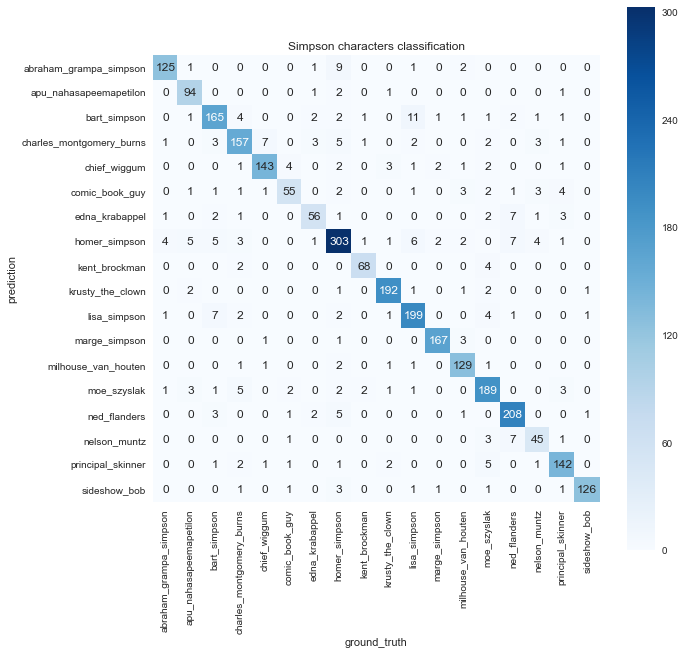

In [16]:
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
df = pd.DataFrame(conf_mat, index=classes, columns=classes)

fig = plt.figure(figsize = (10,10))
sns.heatmap(df, annot=True, square=True, fmt='.0f', cmap="Blues")
plt.title('Simpson characters classification')
plt.xlabel('ground_truth')
plt.ylabel('prediction')

plt.show()

我們可以看到，有一些角色與其角色混在一起:

* Abraham : 他和Homer（他的兒子）混淆了，這很正常, 兒子長的像爸爸。
* Bart : 他與Lisa（他的妹妹）混在一起，可能是因為他們有一些共同的照片：也許我們需要清理一點數據集。

## 總結 (Conclusion)

在這篇文章中有一些個人學習到的一些有趣的重點:
* 深度學習也可以很生活化
* 透過自己常接觸的、喜歡的或有興趣的圖像資料來學卷積神經網絡會更能夠掌握這個技術的應用
* 人人都可以擁有自己的訓練圖像資料集
* 圖像增加法(Data Augmentation)在這次的訓練裡並沒有讓模型效能好, 或許需要增加訓練的循環

參考:
* [The Simpsons characters recognition and detection using Keras (Part 1)](https://medium.com/alex-attia-blog/the-simpsons-character-recognition-using-keras-d8e1796eae36)
* [The Simpsons Characters Data](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/kernels)
* [Keras官網](http://keras.io/)